## NLP HepsiBurada Dataset Sentiment Classification with Sequential ANN and RNN Models 

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#df = pd.read_csv('/content/drive/MyDrive/hepsiburada.zip', encoding="utf-8")
df = pd.read_csv('hepsiburada.zip', encoding="utf-8")

In [3]:
df.head()

,Rating,Review
0,1,3 yıldır tık demedi. :)
1,1,3 yıldır kullanıyorum müthiş
2,1,Ürün bugün elime geçti çok fazla inceleme fırs...
3,1,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,1,Günlük kullanımınızı çok çok iyi karsılıyor kı...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243497 entries, 0 to 243496
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Rating  243497 non-null  int64 
 1   Review  243497 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


In [5]:
df.Rating = df.Rating.map({1:0, 0:1})

# we make our target class 1

In [6]:
df.Rating.value_counts()

Rating
0    229821
1     13676
Name: count, dtype: int64

In [7]:
df.Rating.value_counts(normalize=True)

Rating
0    0.943835
1    0.056165
Name: proportion, dtype: float64

## Train Test Split

In [8]:
X = df['Review']
y = df['Rating']

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

## Tokenization

In [10]:
num_words = 15001 # We write 1 more. First 15K tokens in the word_index

tokenizer = Tokenizer(num_words=num_words) #filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890'
# The tokenizer function splits all text into word tokens.
# The num_words hyperparameter indicates that when converting tokens to numeric, the first 15,000 tokens that occur in the train data/corpus will be converted to numeric version and the other tokens will be ignored.
# If num_words is set to None, all words/tokens will be converted to numeric version. However, assigning None to num_words will return an error when giving data to the DL model. 
# Therefore num_words should always be set to an integer number. 
# With the filters hyper_parameter we can set the cleaning operations to be performed. If we also want to clean numbers, we can include numbers in the filters hyper_parameter.

In [11]:
tokenizer.fit_on_texts(X_train)

# fit_on_texts first breaks down the texts in the train data/corpus into tokens and then identifies all unique tokens and numbers them according to their frequency of use. The most frequently used token is given the number 1.
# Since we defined num_words= 15001, tokens with numbers between 1 and 15000 will be used in the transformation phase and the others will be ignored.
# To see the ranking of the frequency of use of these tokens, we will need to use the word_index function as below.

## Creating word index

In [12]:
tokenizer.word_index

# word_index sorts the tokens in the train data/corpus according to their frequency of use.

{'çok': 1,
 'bir': 2,
 've': 3,
 'ürün': 4,
 'bu': 5,
 'iyi': 6,
 'güzel': 7,
 'için': 8,
 'tavsiye': 9,
 'ederim': 10,
 'daha': 11,
 'ama': 12,
 'da': 13,
 'gayet': 14,
 'hızlı': 15,
 'teşekkürler': 16,
 'aldım': 17,
 'de': 18,
 'ürünü': 19,
 'gibi': 20,
 'yok': 21,
 'uygun': 22,
 'olarak': 23,
 'kaliteli': 24,
 'en': 25,
 'kargo': 26,
 '2': 27,
 'fiyat': 28,
 'elime': 29,
 'kadar': 30,
 'ile': 31,
 'göre': 32,
 'geldi': 33,
 'hepsiburada': 34,
 'var': 35,
 'ben': 36,
 'gerçekten': 37,
 '1': 38,
 'fiyata': 39,
 'gün': 40,
 'sonra': 41,
 'cok': 42,
 'kesinlikle': 43,
 'telefon': 44,
 'biraz': 45,
 'ulaştı': 46,
 'memnun': 47,
 'hiç': 48,
 'değil': 49,
 'hem': 50,
 'kullanışlı': 51,
 '3': 52,
 'mükemmel': 53,
 'oldu': 54,
 'kullanıyorum': 55,
 'önce': 56,
 'sipariş': 57,
 'tek': 58,
 'her': 59,
 'bence': 60,
 'harika': 61,
 'kalitesi': 62,
 'bi': 63,
 'ayrıca': 64,
 '5': 65,
 'teşekkür': 66,
 'olması': 67,
 'fiyatı': 68,
 'ne': 69,
 'herkese': 70,
 'bile': 71,
 'uzun': 72,
 'süper': 73,

In [13]:
len(tokenizer.word_index)
# There are a total of 205230 unique tokens in our train data/corpus.

205230

## Converting tokens to numeric

In [14]:
X_train_num_tokens = tokenizer.texts_to_sequences(X_train) # Converted to numeric version according to unique tokens in X_train
X_test_num_tokens = tokenizer.texts_to_sequences(X_test)   # Converted to numeric version according to unique tokens in X_train to avoid data lekage

# texts_to_sequences function converts all tokens in each document/line of our data according to the numbers that indicate the frequency of use of the train data in the word_index 
# (num_words=15001 so only the first 15000 most frequently used tokens will be used).
# Example: "This product is very good, I recommend it" comment --> This: 5, product: 4, very: 1, nice: 7, recommend: 9, would: 10 into the vector [5, 4, 1, 7, 9, 9, 10]. 
# Note that these transformations are based on the top 15,000 most frequent tokens in the corpus. 
# If the "I would" token was the 15,001st token or higher, the "I would" token would be ignored during the transformation and the resulting vector would be [5, 4, 1, 7, 9].

In [1]:
# DL models always require vectors of fixed size. Here the vector sizes are variable depending on the interpretation. This is why we get an error
# np.array(X_train_num_tokens).shape()

In [16]:
len(X_train_num_tokens)

219147

In [17]:
X_test[:2]

143605    ürünü yaklaşık 2 senedir kullaniyorum. bu fiya...
133710    Ürünün tüm aparatlarını kullandım . Tereddüt e...
Name: Review, dtype: object

In [18]:
np.array(X_test_num_tokens[:2], dtype="object")
# we see the numeric vectors of the first two comments.

array([list([19, 163, 27, 1047, 623, 5, 39, 25, 22, 669, 966, 225, 9, 10]),
       list([110, 173, 13278, 141, 236, 518, 106, 221, 68, 1146, 1, 435, 976, 4049, 4056, 10805, 15, 81, 3, 411, 1647, 35, 1705, 3, 173, 1073, 923, 1850, 551, 154, 13, 8050, 919, 5065, 5385, 368, 894, 4049, 243, 653, 1, 177, 2267, 8, 113, 5841, 2, 268, 2164, 1188, 13, 212])],
      dtype=object)

In [19]:
X_test.iloc[10]

'ürünün kalitesi ortada fiyata gelince samsung türkiye garantili olup tüm renk seçenekleri ile en uygun satıcı hepsiburada'

In [20]:
X_test_num_tokens[10]

[110,
 62,
 1440,
 39,
 436,
 228,
 771,
 525,
 992,
 173,
 419,
 4129,
 31,
 25,
 22,
 393,
 34]

## Maximum number of tokens for all documents

In [21]:
len(X_train_num_tokens[105])

# The 105th comment in the train data consists of 1 token.

1

In [22]:
len(X_train_num_tokens[106])

# The 106th comment in the train data consists of 17 tokens.

17

In [23]:
len(X_train_num_tokens[6150])

# ML/DL models want all the data given to them to have the same dimensions. But as you can see, all the comments have different sizes.

17

In [24]:
num_tokens = [len(sen_tokens) for sen_tokens in X_train_num_tokens]
num_tokens = np.array(num_tokens)


# first we write the size of all comments in the train corpus into a list and assign it to the variable num_tokens.
# We convert the list to an arrey, since the aggregation functions can be conveniently applied to arrears.

In [25]:
num_tokens

# we see how many tokens each comment/document consists of.

array([45,  9, 22, ...,  8,  6,  5])

In [26]:
num_tokens.max()

# we saw that the longest comment consists of 297 tokens.
# What number should we pin all documents to?

297

In [27]:
num_tokens.argmax()

# we can find the index of the longest comment in the list with argmax.

159025

In [28]:
X_train.iloc[159025]

'Özellikle bu kısma yazıyorum iyice okuyunuz,cihazın hızı çok iyi.Isınma normal boyutlarda.Kamerası elinizi sabit tutarsanız ve gündüz çok net gece ise çok net çekmez.Görüntülü konuşma özelliği yok ancak uygulama ile olur,anten çekimi gayet iyi.Parmak izi okuyucusu gayet hızlı bazen tuşu silmenizi istiyor ve okuyamıyor kirden vs...Ön kamera da tatmin edici,çekim esnasında ekran beyaz ışık vererek flaş görevi görür.Batarya bana 1 hafta gidiyor sık kullanımda ise 2-3 gün gidiyor.Hızlı şarj 1 saatte doluyor , şekilleri ele oturuyor ve şık bir görüntü var.Telefonu aldığım gün gittim ve ilk girdiğim yerden ekran koruyucu ve kılıf buldum.Kulaklık sesi çok net ve yüksek ancak kendi hoparlörü biraz zayıf sesi.Ekrana bakarken açık kalma özelliği yok.Diğer akıllı cihaz özellikleri %90 ı bu cihazda mevcut.Güç tasarrufu 2 ayrı modu var ve çok başarılı çalışıyor.4gb ram var genelde yarısı boş kalıyor.Bir de yeni cihazların çoğu titreşimi az ve sesi de az çıkıyor.Bu cihaz da içine dahil...Bu cihazla

In [29]:
len(X_train_num_tokens[159025])

# We need to make all comments in our corpus the same size. It is actually recommended to fix all comments to 297, the length of the longest comment, to avoid any loss of information/token loss in the comments. 
# But this will cost us a lot of work.
# if you have very powerful machines, of course it makes the most sense to fix all comments to the size of the longest comment.
# However, if our machines are not powerful, we need to fix smaller sizes. 
# When deciding this, we can set the number so that 95% or more of the comments in our corpus have no information/token loss (5% or less token/information loss).

297

In [30]:
list = [5, 10, 8, 9, 12, 15]
print(np.array(list) <= 11)
print(sum(np.array(list) <= 11))
print(sum(np.array(list) <= 11)/len(list))

# Example: Suppose there are 6 comments in our corpus. the first comment has 5 tokens, the second has 10 tokens, the third has 8 tokens, the fourth has 9 tokens, the fifth has 12 tokens and the sixth has 15 tokens.

# Let's see how many comments will not lose any information/token if I fix all comments to 11 tokens.

# the first 4 comments will not lose any information/token, but comment 5 will lose 1 token and comment 6 will lose 4 tokens.
# With the code np.array(list) <= 11, when we fix all comments to 11 tokens, I make sure that comments with no information/token loss are returned as True and comments with information/token loss are returned as False --> [ [ True True True True True False False False]
# sum(np.array(list) <= 11) first converts Truelar to 1 and Falselar to 0. Then these values are summed. The result shows us how many comments have no information/token loss.
# [True True True True True True False False]-->[1 1 1 1 1 1 0 0]--> sum([1 1 1 1 1 1 0 0])-->4 --> 4 out of 6 comments in my cospusum have no information/token loss.
# Dividing the result 4 by the number of comments in our corpus (len([5, 10, 8, 9, 12, 15])-->6) gives us a ratio of how many comments have no information/token loss (4/6 --> 0.67). We want this ratio to be 95% and above.

[ True  True  True  True False False]
4
0.6666666666666666


In [31]:
max_tokens = 61

In [32]:
sum(num_tokens <= max_tokens) / len(num_tokens)

# We set up the same equation here as in our example above. and the max_tokens will be above 95%.
# We manually control this. If I set it to 61 tokens, I saw that 96% of the comments in my corpus will not lose information/tokens, so I will continue with max_tokens = 61.

0.961678690559305

In [33]:
sum(num_tokens <= max_tokens)

# When max_tokens = 61, there is no loss of information/token in 210749 of the total 219147 comments in my train data/cospusum.

210749

In [34]:
len(num_tokens)

# of all documents/lines/comments in my train data

219147

## Fixing token counts of all documents (pad_sequences)

In [35]:
X_train_pad = pad_sequences(X_train_num_tokens, maxlen=max_tokens, padding="pre") # padding="pre", padding and cropping are done from the beginning.
X_test_pad = pad_sequences(X_test_num_tokens, maxlen=max_tokens, padding="pre")   # padding=“post”, padding and cropping are done from the end.
                                                                                  # try both and go with the one that gives the best results.

# The pad_sequences function is given the numeric versions of the comments and the length to be padded (maxlen) and all comments are padded to 61 tokens.
# This operation is called padding. However, don't let the name mislead you, this operation is not only padding but also trimming/trimming.
# Comments with fewer than 61 tokens are padded with 0s, which are added to the beginning of the comment. For example, a comment with 50 tokens will be padded with 11 0's so that it is fixed to 61 tokens. (if padding=“pre”)
# Comments with more than 61 tokens will have their tokens trimmed to the beginning of the comment. For example, a comment with 71 tokens will have the first 10 tokens at the beginning of the comment trimmed so that the comment is fixed to 61 tokens.(if padding=“pre”)
# No addition or trimming is done to a comment consisting of 61 tokens. It is left as it is.
# We assign our comments fixed to 61 tokens to the X_pad variable.

In [36]:
display(X_train_pad.shape)
display(X_test_pad.shape)

# we see that all comments are pinned to 61 tokens.
# We named it X_pad to indicate that it is padded data.

(219147, 61)

(24350, 61)

In [37]:
np.array(X_test_num_tokens[800])

array([   4, 2788,   74, 4109,   88,  368,  195,   18, 3168,   33,  153,
       1381, 3758,  277,  210])

In [38]:
len(np.array(X_test_num_tokens[800]))
# we see that the 800th comment in the test data consists of 15 tokens.

15

In [39]:
X_test_pad[800]

# After padding, 46 0's are added at the beginning of the comment to be fixed to 61 tokens.

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    4, 2788,   74, 4109,   88,  368,  195,   18, 3168,
         33,  153, 1381, 3758,  277,  210])

In [40]:
np.array(X_train_num_tokens[159025])

# now let's see what happens if we apply padding to the longest document/comment in the train data/corpus consisting of 297 tokens.

array([  144,     5,  6034,  2262,  1616,   911,   203,     1,     6,
        2938,   164,  4523,   374,  3443,  1531, 13099,     3,  1391,
           1,   493,   280,   140,     1,   493,  3267,  2386,   239,
          21,    82,   760,    31,   212,  4785,  1431,    14,     6,
         471,   607,  2161,    14,    15,   664,  1736,  2166,     3,
         313,   444,   258,    13,   568,   460,   468,  1649,   166,
         648,   509,  3232,  5471,  6629,   604,   620,   153,    38,
         194,   273,   632,   404,   140,    27,    52,    40,   273,
          15,    81,    38,   461,  1670, 12275,  1038,   982,     3,
          96,     2,   317,    35,   134,   170,    40,  2837,     3,
          76,   751,   166,   906,     3,   515,   573,   362,   195,
           1,   493,     3,   172,    82,   255,  6411,    45,   925,
         195,  2075,  7012,   599,  7808,   239,    21,   104,   928,
         135,   391,  1303,  1875,     5,  2156,   569,  1053,  2204,
          27,   335,

In [41]:
X_train_pad[159025]

# As you can see, the first 236 tokens at the beginning of the comment are clipped to be fixed at 61 tokens.

array([ 881, 3415,  534, 1773,  485, 2208,   75,  164,    2,  443,   13,
       1284, 1840, 3302,    5,  822, 7712,  856, 1658, 7573, 3445,   12,
       1284,   31, 3099,  300, 2720,  854, 1052,   39, 1478, 3341,  319,
       1188,   75,  534,   49,  331,  248, 1317,  120,    2, 3341, 7321,
        200,  269,  577, 5857, 1869,   13,   45,  805,  108,    3,  866,
        758, 5709,   49,  106,   77,  886])

## Modelling

In [42]:
model = Sequential()

# This function represents a model in a sequential manner, i.e. a model in which layers follow one another in succession.
# The Sequential model contains layers whose output goes into the next layer.
# Layers are added to the Sequential model with the add method.

In [43]:
embedding_size = 50

# Here we specify how many elements/dimensional vector we want each token to be given to the DL model.
# Although best practice usually prefers numbers like 50, 100, 300, you can choose the number you want. However, the larger this number is, the more it will cost us.

## Recommended Number of Neurons in ANN Models

There are several different approaches to plan the number of neurons in a deep learning model with more than one hidden layer **(ANN)**.

**Growing number of neurons**: More neurons are used in the first hidden layer and the number of neurons is reduced in each subsequent layer. In this approach, more features are learned in earlier layers and fewer features are learned in later layers.

**Fixed number of neurons**: The same number of neurons is used in each layer. In this approach, each layer is considered to have the same importance.

**Increasing number of neurons**: A small number of neurons are used in the first hidden layer and the number of neurons is increased in each subsequent layer. This approach allows more features to be learned in later layers.

Trial and error is recommended to find the best among these methods. Also, it is necessary to conduct experiments to understand the effects of the number of hidden layers, number of neurons, optimization functions, batch size, etc. hyperparameters to choose the best one.

**As a hypothesis, it can be argued that using more neurons in the first layers may result in a wider feature space coverage and hence better feature learning. However, since it may not always be the best choice for performance, it is recommended that you try them all and get the best result through experiments.

## Recommended Number of Neurons in RNN Models:

**Growing number of neurons:** More neurons are used in the first LSTM&GRU layer and the number of neurons is reduced in each subsequent layer. In this approach, more features are learned in earlier layers and fewer features are learned in later layers.

As a best practice, the recommended number of neurons for the first layer is the size of the word embedding we give to the model. If the word embedding consists of 50 elements, the number of neurons in the first layer should start with 50 and gradually decrease. However, you should experiment and see which number of neurons gives the best results.

If the “return_sequences” hyper_parameter of the LSTM and GRU layers is set to True, the hidden states in all time steps shown below are fed to the next LSTM/GRU layer. If False, only the last hidden state is fed to the next layer.

 If the layer following an LSTM/GRU layer is an LSTM/GRU layer, the hyper_parameter “return_sequences” must be set to True otherwise the model will not work and will return an error.

 If the layer following an LSTM/GRU layer is a Dense layer, the “return_sequences” hyper_parameter must be set to False otherwise the model will not work and will return an error.

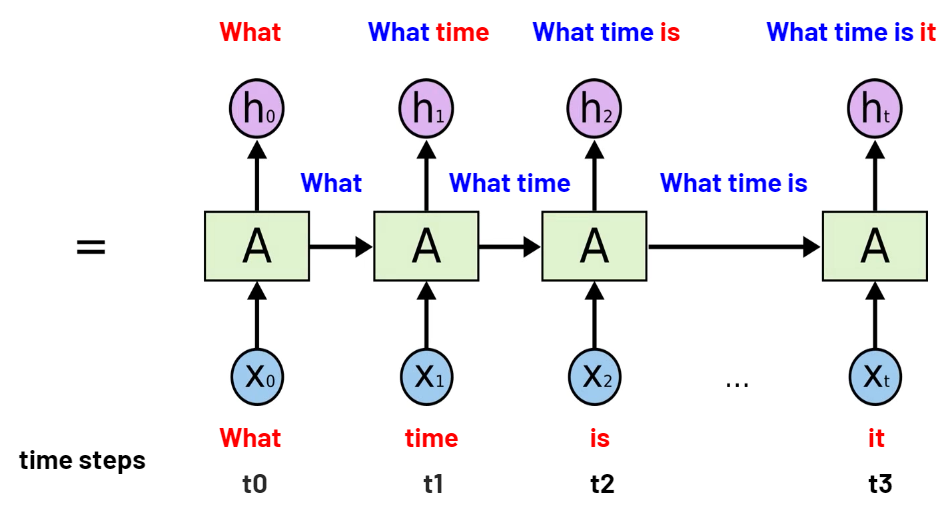

In [44]:
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens))

# Embedding layer is a layer used in NLP models and consists of a 3D tensor.
# 1st dimension is the total number of comments in the train set.
#2 how many tokens each comment consists of (max_tokens).
# The 3rd dimension is a vector of how many elements the word embedding of each token consists of (embedding_size).
# Since the first 15000 most frequent tokens in the train corpus are used when converting tokens to numeric version, both in train and predicit phase
# We set imput_dim = num_words in the Embedding layer so that the model can check if only the first 15000 tokens that occur most frequently in the train corpus are used.
# If you make imput_dim smaller than 15,000 (like 10000) then the model will train and predict with the first 10000 most frequent tokens in the corpus.

model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=True))

# return_sequences=False transfers only the hidden_state from the last time step (t_n) of the model to the next layer. default is False.
# return_sequences= True transfers hidden_states from all time steps of the model (such as t_0, t_1, t_2 .....t_n) to the next LSTM, GRU layers.
# This way the model tries to remember the whole sentence. If an LSTM/GRU layer is followed by another LSTM/GRU layer, return_sequences=True
# must be set or the model will return an error. However, if the next layer is a dense layer, return_sequences=False must be set otherwise the model will return an error.
# returns. Because Dense layers work with only one hidden_state.
model.add(Dropout(0.2))

model.add(GRU(units=25, return_sequences=True))
model.add(Dropout(0.2))
# since the next layer is the GRU layer, we set return_sequences=True.

model.add(GRU(units=12, return_sequences=False))
# next layer is dense layer so we set return_sequences=False.


model.add(Dense(1, activation='sigmoid'))

In [45]:
# The rate set during the dropout process refers to how many neurons will be turned off on average. For example, during dropout(0.5), at each iteration
# 50% of the neurons are randomly switched off, but this rate may not be exactly the same in each iteration. For example, it might be 0.3 in one iteration and 0.7 in another iteration
# but the average is always 0.5.
# So the ratio can change in each iteration, as you can imagine.

In [46]:
optimizer = Adam(learning_rate=0.008)

In [47]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['Recall'])

# compile is where we edit the optimization parameters.
# compile parameters are the choice of the gradient descent algorithm that we will use in the optimization of the DL model, the loss function
# and includes metrics to be followed during optimization processes. The details are as follows.
# loss: The loss function to be used to optimize the model. For example, classification :binary_crossentropy or categorical_crossentropy,
# regression:mse
# optimizer The optimization algorithm that will be used to optimize the weights of the model. For example, SGD, Adam or RMSprop.
# metrics: The metrics that will be used to evaluate the performance of the model. For example, accuracy, precision or recall.

https://stats.stackexchange.com/questions/328926/how-many-parameters-are-in-a-gated-recurrent-unit-gru-recurrent-neural-network

In [48]:
model.summary()
# embedding_size * num_words ==> 50 * 15001 ==> 750050

# 3 x (n2 + nm + 2n) m= input, n= output
# (50*50 + 50*50 + 2*50)*3 = 15.300 ==> m = 50, n = 50
# (25*25 + 50*25 + 2*25)*3 = 5775   ==> m = 50, n = 25
# (12*12 + 25*12 + 2*12)*3 = 1404   ==> m = 24, n = 12
# (12+1)*1 = 13 ==> (input+bias)*output

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 61, 50)            750050    
                                                                 
 dropout (Dropout)           (None, 61, 50)            0         
                                                                 
 gru (GRU)                   (None, 61, 50)            15300     
                                                                 
 dropout_1 (Dropout)         (None, 61, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 61, 25)            5775      
                                                                 
 dropout_2 (Dropout)         (None, 61, 25)            0         
                                                                 
 gru_2 (GRU)                 (None, 12)                1

In [49]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_recall",
                           mode="max",
                           patience = 1,
                           restore_best_weights=True,
                           verbose=1)

In [60]:
#from sklearn.utils import class_weight
#classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
#pd.Series(classes_weights).unique()

In [50]:
weights = {0:0.05, 1:0.95}

https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

In [51]:
model.fit(X_train_pad,
          y_train,
          epochs=10,
          batch_size=256,
          class_weight=weights,   #sample_weight= classes_weights
          validation_data=(X_test_pad, y_test),
          callbacks=[early_stop])

Epoch 1/10
857/857 [==============================] - 61s 54ms/step - loss: 0.0319 - recall: 0.8747 - val_loss: 0.1835 - val_recall: 0.8757
Epoch 2/10
857/857 [==============================] - 47s 55ms/step - loss: 0.0197 - recall: 0.9355 - val_loss: 0.2786 - val_recall: 0.9181
Epoch 3/10
857/857 [==============================] - 52s 61ms/step - loss: 0.0152 - recall: 0.9557 - val_loss: 0.2476 - val_recall: 0.8925
Epoch 3: early stopping


## Model evaluation

In [52]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,recall,val_loss,val_recall
0,0.031860,0.874716,0.183527,0.875731
1,0.019719,0.935489,0.278598,0.918129
2,0.015248,0.955720,0.247595,0.892544


<Axes: >

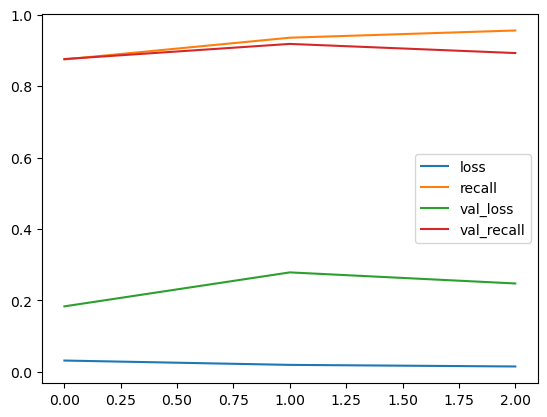

In [53]:
model_loss.plot()

In [54]:
model.evaluate(X_test_pad, y_test)

761/761 [==============================] - 21s 28ms/step - loss: 0.2786 - recall: 0.9181


[0.2785980999469757, 0.9181286692619324]

In [55]:
model.evaluate(X_train_pad, y_train)

   1/6849 [..............................] - ETA: 10:46 - loss: 0.4087 - recall: 1.0000

6849/6849 [==============================] - 211s 31ms/step - loss: 0.2299 - recall: 0.9849


[0.22994042932987213, 0.9848878979682922]

In [56]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

y_pred = model.predict(X_test_pad) >= 0.5

print(confusion_matrix(y_test, y_pred))
print("-------------------------------------------------------")
print(classification_report(y_test, y_pred))

761/761 [==============================] - 25s 28ms/step
[[20393  2589]
 [  112  1256]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     22982
           1       0.33      0.92      0.48      1368

    accuracy                           0.89     24350
   macro avg       0.66      0.90      0.71     24350
weighted avg       0.96      0.89      0.91     24350



In [57]:
y_train_pred = model.predict(X_train_pad) >= 0.5

print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

   3/6849 [..............................] - ETA: 3:31 

6849/6849 [==============================] - 201s 29ms/step
[[186719  20120]
 [   186  12122]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    206839
           1       0.38      0.98      0.54     12308

    accuracy                           0.91    219147
   macro avg       0.69      0.94      0.75    219147
weighted avg       0.96      0.91      0.93    219147



  3/761 [..............................] - ETA: 21s 

761/761 [==============================] - 23s 30ms/step


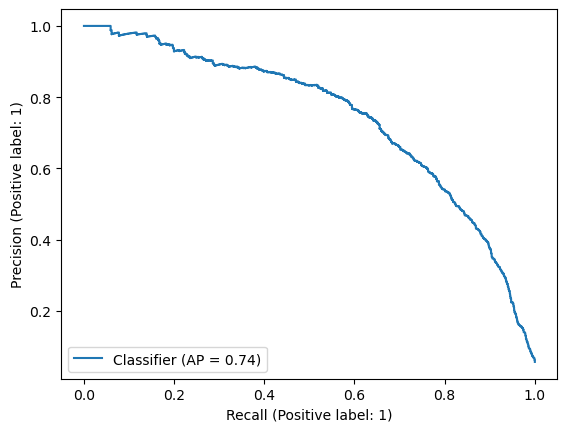

In [58]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_pred_proba = model.predict(X_test_pad)

PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.show();

In [59]:
from sklearn.metrics import precision_recall_curve, average_precision_score

average_precision_score(y_test, y_pred_proba)

0.7427609442553536

## Scores without sample_weight

Test set

                precision    recall  f1-score   support

           0       0.98      0.99      0.98     45965
           1       0.72      0.63      0.67      2735

    accuracy                           0.97     48700
   



 Train set

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    183856
           1       0.87      0.80      0.84     10941

    accuracy                           0.98    194797
   

## Model Saving

In [60]:
#model.save('/content/drive/MyDrive/review_hepsiburada.h5')

##Loading Model

In [61]:
#from tensorflow.keras.models import load_model
#model_review = load_model('/content/drive/MyDrive/review_hepsiburada.h5')

## Tokenizer Saving

In [62]:
#import joblib

# Save the Tokenizer
#joblib.dump(tokenizer, '/content/drive/MyDrive/tokenizer.joblib')

Using #pickle or joblib libraries we can save our tokenizar algorithm to drive.

## Loading Tokenizer

In [63]:
#import joblib

# Load the Tokenizer
#loaded_tokenizer = joblib.load('/content/drive/MyDrive/tokenizer.joblib')

Using #pickle or joblib libraries we can call our tokenizer algorithm from drive.

## Predicton

In [64]:
review1 = "çok beğendim herkese tavsiye ederim"
review2 = "süper ürün"
review3 = "büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım"
review4 = "kelimelerle tarif edilemez"
review5 = "tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten"
review6 = "hiç resimde gösterildiği gibi değil"
review7 = "kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım."
review8 = "hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum"
review9 = "tam bir fiyat performans ürünü"
review10 = "beklediğim gibi çıkmadı"
review11 = "on numara beş yıldız"
review12 = "üründe sıkıntı var"
review13 = "televizyonun görüntü kalitesi çok kötü, dün akşam evde arkadaşlarla toplandık. yedik, içtik, sohbet ettik. Sonra televizyonda Türkiye - İngiltere maçını seyrettik."
review14 = '1 gün gibi kısa bir sürede elime geçti. Ve bu fıyata süper bir ürün tavsiye ederim. Lakin eli büyük olan kişiler daha büyük modelini tercih edebilirler ortaboy ürün.Teşekkürler '
review15 = 'telefon kesinlikle bu parayı hak etmiyor. yeni hiç bir özelliği yok. ancak küçük ekran sevenler için iyi bir telefon'
review16 = 'müthiş bir telefon ama bu parayı hak etmiyor'
reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10, review11, review12, review13, review14, review15, review16]

# Now we will get predictions

In [65]:
tokens = tokenizer.texts_to_sequences(reviews)

# First of all, we convert the texts that we will predict into numeric version according to the most used 15000 tokens in our data as in train data.
# Since the conversions are made according to the first 15000 most frequently used tokens in train data, tokens other than the first 15000 tokens are ignored in the predict phase.

In [66]:
np.array(tokens, dtype="object")

array([list([1, 146, 70, 9, 10]), list([73, 4]),
       list([103, 2, 1031, 2290, 1459, 5, 19, 5, 1784, 11674]),
       list([4235, 11684]),
       list([556, 61, 82, 26, 1, 445, 33, 3, 4, 1031, 2290, 37]),
       list([48, 1103, 6142, 20, 49]),
       list([177, 746, 7522, 82, 261, 105, 326]),
       list([48, 5, 30, 177, 2, 1742, 1235, 4, 1755, 4934, 84]),
       list([74, 2, 28, 111, 19]), list([636, 20, 859]),
       list([392, 178, 1007, 513]), list([453, 147, 35]),
       list([6953, 317, 62, 1, 177, 376, 475, 286, 6350, 1380, 41, 9533, 771]),
       list([38, 40, 20, 108, 2, 161, 29, 149, 3, 5, 2891, 73, 2, 4, 9, 10, 1191, 2394, 103, 113, 2024, 11, 103, 1155, 176, 12442, 4, 16]),
       list([44, 43, 5, 1242, 490, 733, 136, 48, 2, 239, 21, 82, 116, 166, 1620, 8, 6, 2, 44]),
       list([585, 2, 44, 12, 5, 1242, 490, 733])], dtype=object)

In [67]:
tokens_pad = pad_sequences(tokens, maxlen=max_tokens, padding="pre")
tokens_pad.shape

# we pin all comments to 61 tokens as in train data.

(16, 61)

In [68]:
prob = model.predict(tokens_pad)
prob

1/1 [==============================] - 0s 90ms/step


array([[0.00898187],
       [0.01864271],
       [0.99507326],
       [0.08422784],
       [0.933224  ],
       [0.9927583 ],
       [0.89101076],
       [0.6420881 ],
       [0.02815365],
       [0.9731959 ],
       [0.01186326],
       [0.90065724],
       [0.9951212 ],
       [0.20122494],
       [0.9922849 ],
       [0.9521326 ]], dtype=float32)

In [69]:
[i[0] for i in prob]

[0.008981871,
 0.01864271,
 0.99507326,
 0.08422784,
 0.933224,
 0.9927583,
 0.89101076,
 0.6420881,
 0.028153654,
 0.9731959,
 0.011863262,
 0.90065724,
 0.9951212,
 0.20122494,
 0.9922849,
 0.9521326]

In [70]:
pred = (model.predict(tokens_pad) >0.5).astype("int")
pred

1/1 [==============================] - 0s 80ms/step


array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1]])

In [71]:
[i[0] for i in pred]

[0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]

In [72]:
pd.set_option('display.max_colwidth', None) # None/-1 sets the cell width to the longest comment/line.
my_dict = {"Review":reviews, "prob":[i[0] for i in prob], "classes":[i[0] for i in pred]}
pd.DataFrame(my_dict)

# Since DataFrame wants all featurers to be the same size, we reduce the probe and classes featurers from 2 sizes to one size.
# This way all featurers have the same size.

,Review,prob,classes
0,çok beğendim herkese tavsiye ederim,0.008982,0
1,süper ürün,0.018643,0
2,büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım,0.995073,1
3,kelimelerle tarif edilemez,0.084228,0
4,tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten,0.933224,1
5,hiç resimde gösterildiği gibi değil,0.992758,1
6,kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım.,0.891011,1
7,hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum,0.642088,1
8,tam bir fiyat performans ürünü,0.028154,0
9,beklediğim gibi çıkmadı,0.973196,1


END OF THE PROJECT